In [3]:
pip install circe-py

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import circe as ci
import circe.metacells as circe_metacells
import scanpy as sc
import scipy as sp

# Test with sparse covariance true matrix as GT

### 0. Create fake AnnData

This data doesn't contain strong correlation between fake regions, the score will then be low. 

It will still allow us to demonstrate how to use Circe. :)

In [5]:
atac = sc.datasets.blobs(n_centers=10, n_variables=2_000, n_observations=300, random_state=0)
atac.X = np.random.poisson(lam=1, size=atac.X.shape)
cell_names = [f"cell_{i}" for i in range(1, atac.shape[0]+1)]
# number of chr_start_end region names
region_names = [[f"chr{i}_{str(j)}_{str(j+150)}" 
                 for j in range(1, 10000*400+1, 10000)] 
                for i in range(1, 6)]
regions_names = [item for sublist in region_names for item in sublist]
atac.var_names = regions_names
atac.obs_names = cell_names

In [6]:
distance_threshold = 250_000

### 1. Add region position in AnnData.obs

In [7]:
atac = ci.add_region_infos(atac)

### 2. Replace random data with fake cov matrix

### 2.A. Remove Null rows

In [8]:
sc.pp.filter_genes(atac, min_cells=1,)
sc.pp.filter_cells(atac, min_genes=1,)
atac

/home/rtrimbou/miniconda3/envs/test_circe_pip/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


AnnData object with n_obs × n_vars = 300 × 2000
    obs: 'blobs', 'n_genes'
    var: 'chromosome', 'start', 'end', 'n_cells'

### 2.B. Compute pseudocells

In [9]:
metacells = circe_metacells.compute_metacells(atac)

Output()

### 3 Calculate co-accessibility

In [10]:
ci.compute_atac_network(
    atac, #metacells,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=100
)

Output()

Output()

Output()

Averaging co-accessibility scores across windows...
Done !


*1. Circe can also work with sparse covariance matrix.*<br>
*2. Connections can also be stored externally using 'sliding_graphical_lasso'.*

In [11]:
atac.X = sp.sparse.csr_matrix(atac.X)
# atac.X = atac.X.toarray()

In [12]:
final_score = ci.sliding_graphical_lasso(
    atac,
    window_size=distance_threshold,
    unit_distance = 1000,
    distance_constraint=distance_threshold/2,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500
)
atac.varp['atac_network'] = final_score

Output()

Output()

Output()

Averaging co-accessibility scores across windows...
Done !


### 3. B. Extract list of edges

In [13]:
circe_network = ci.extract_atac_links(atac) #metacells)
circe_network

,Peak1,Peak2,score
493,chr1_800001_800151,chr1_900001_900151,0.165401
2285,chr1_3660001_3660151,chr1_3720001_3720151,0.127582
5339,chr3_90001_90151,chr3_180001_180151,0.113825
2062,chr1_3170001_3170151,chr1_3300001_3300151,0.112355
7544,chr3_3480001_3480151,chr3_3520001_3520151,0.112348
...,...,...,...
6336,chr3_1740001_1740151,chr3_1780001_1780151,-0.086076
10859,chr5_600001_600151,chr5_670001_670151,-0.095203
13263,chr5_3810001_3810151,chr5_3990001_3990151,-0.096495
3747,chr2_1480001_1480151,chr2_1500001_1500151,-0.097660


### 4. Plot co-accessibility scores in a window

0.06280730718762548


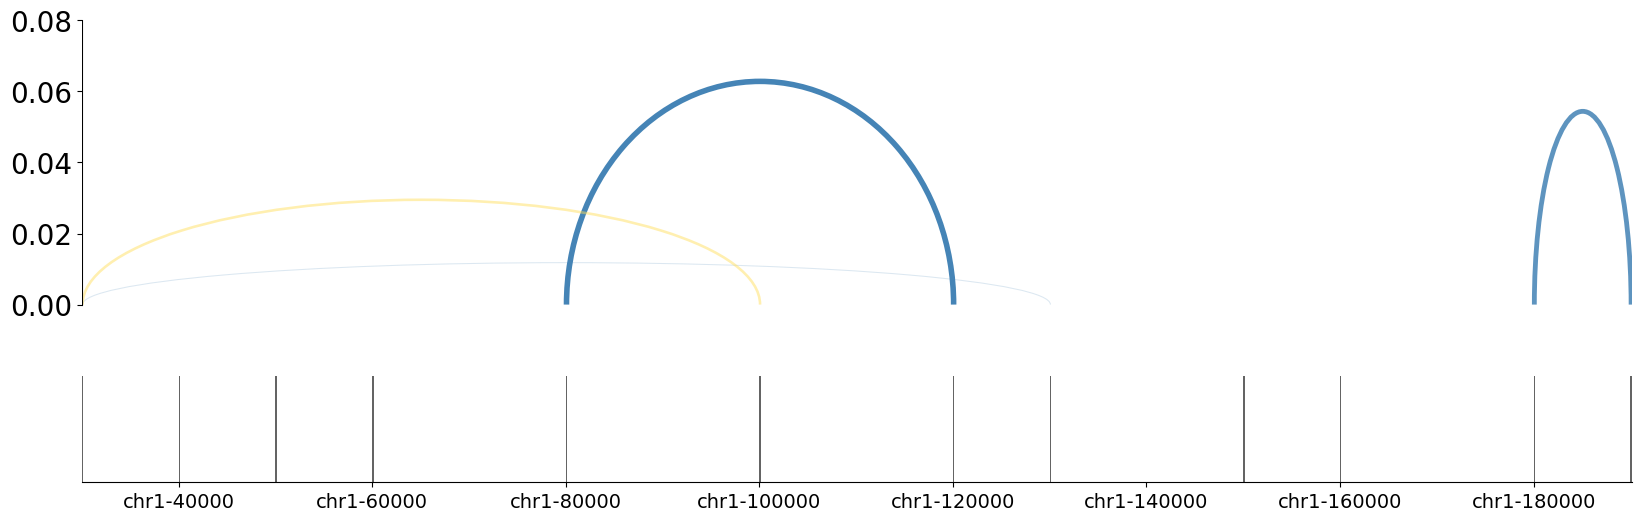

In [14]:
ci.plot_connections(
    circe_network,
    chromosome="chr1",
    start=10_000,
    end=200_000,
    sep=("_","_"),
    abs_threshold=0.01
)

### 5. Subset the AnnData object to a given window

In [17]:
subset_atac = ci.subset_region(atac, "chr1", 10_000, 200_000)

In [18]:
df = ci.extract_atac_links(subset_atac)
df

/home/rtrimbou/miniconda3/envs/test_circe_pip/lib/python3.12/site-packages/circe/circe.py:288: ImplicitModificationWarning: Setting element `.varp['atac_network']` of view, initializing view as actual.
  anndata.varp[key] = anndata.varp[key].tocoo()


,Peak1,Peak2,score
4,chr1_80001_80151,chr1_120001_120151,6.280731e-02
10,chr1_180001_180151,chr1_190001_190151,5.437575e-02
1,chr1_30001_30151,chr1_130001_130151,1.179966e-02
5,chr1_80001_80151,chr1_150001_150151,5.347813e-06
7,chr1_120001_120151,chr1_150001_150151,3.358818e-07
8,chr1_150001_150151,chr1_180001_180151,1.206201e-09
9,chr1_150001_150151,chr1_190001_190151,6.558811e-11
6,chr1_100001_100151,chr1_130001_130151,-3.479782e-04
3,chr1_50001_50151,chr1_160001_160151,-6.601273e-03
2,chr1_40001_40151,chr1_60001_60151,-6.983465e-03
